# Project 2: Classification of Credit Scoring Data

The object of this project is to work with a machine learning model to accurately classify individuals into categories of different _creditworthiness_ based on their historical financial data. Within this project, I am to discover whether an individual is carrying a good or bad credit risk, which enables financial institutions such as a bank on more informed lending decisions.

---

[Link to Dataset](https://www.kaggle.com/datasets/cs49adityarajsharma/credit-scoring-data)


## Objectives
This dataset highlights:

- `Age:` The age of the individual
- `Gender:` The gender of the individual *(Female, Male)*
- `Marital Status:` The marital Status of the individual *(Single, Divorced, Married)*
- `Education Level:` The highest education level obtained by the individual *(Ranges from High School to PhD)*
- `Employment Status:` The current employment status of the individual *(Unemployed, Self-Employed, Employed)*
- `Credit Utilization Ratio:` The ratio of the of credit actually used by the individual compared to their credit limit *(scale of 0–1)*
- `Payment History:` The monthly net behavior of each customer *(accounts for late payments, missed payments, and defaults)*
- `Number of Credit Accounts:` The count of active credit accounts the person has
- `Loan Amount:` The monetary value of the loan a person holds
- `Interest Rate:` The interest rate associated with a loan
- `Loan Term:` The duration of the loan
- `Type of Loan:` Categorizes the loan into labels such as:
    - Personal Loan
    - Auto Loan

The **key** question is:
- Can we accurately classify people into categories such as *Good Credit* or *Bad Credit* based on their historical financial data?

Some additional questions I have regarding this classification are:
1. which financial features (i.e., payment, loan amount, revolving accounts etc.) are the most important for predicting creditworthiness.



## Importing Libraries and Dependencies


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree

## Loading the Dataset

In [31]:
data = pd.read_csv('credit_scoring.csv')

data.head()

,Age,Gender,Marital Status,Education Level,Employment Status,Credit Utilization Ratio,Payment History,Number of Credit Accounts,Loan Amount,Interest Rate,Loan Term,Type of Loan
0,60,Male,Married,Master,Employed,0.22,2685.0,2,4675000,2.65,48,Personal Loan
1,25,Male,Married,High School,Unemployed,0.20,2371.0,9,3619000,5.19,60,Auto Loan
2,30,Female,Single,Master,Employed,0.22,2771.0,6,957000,2.76,12,Auto Loan
3,58,Female,Married,PhD,Unemployed,0.12,1371.0,2,4731000,6.57,60,Auto Loan
4,32,Male,Married,Bachelor,Self-Employed,0.99,828.0,2,3289000,6.28,36,Personal Loan


## Scrubbing / Cleaning of the Data
Before analysis, it is important to clean the data to remove any null values or unnecessary information.

The first step was to check and remove any missing values from the dataset to prevent biased calculations, where inconsistencies, such as missing scoring values, could distort trends and lead to incorrect classifications. The next step is to remove any empty rows within the dataset, then check for any duplicate or missing data. The last step is to drop any duplicate information within the dataset, to help the models make a more accurate prediction.


In [32]:
df = data

missing_values = df.isnull().sum()
print(missing_values)
df.dropna(inplace=True)

df = df.drop_duplicates()


df.info()

Age                          0
Gender                       0
Marital Status               0
Education Level              0
Employment Status            0
Credit Utilization Ratio     0
Payment History              0
Number of Credit Accounts    0
Loan Amount                  0
Interest Rate                0
Loan Term                    0
Type of Loan                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1000 non-null   int64  
 1   Gender                     1000 non-null   object 
 2   Marital Status             1000 non-null   object 
 3   Education Level            1000 non-null   object 
 4   Employment Status          1000 non-null   object 
 5   Credit Utilization Ratio   1000 non-null   float64
 6   Payment History            1000 non-null   float64
 7   

## Starting Visualizations

Before diving into splitting and training the data, we will create some base visualizations to see if there are any patterns.

### Distribution of Education Levels

The first visualization examines the `Distribution of Education Levels` showing roughly how many people fit into each category. Some overall observations are that all educational levels seem to be balanced, however, graduate degrees are *slightly* more common within the dataset.

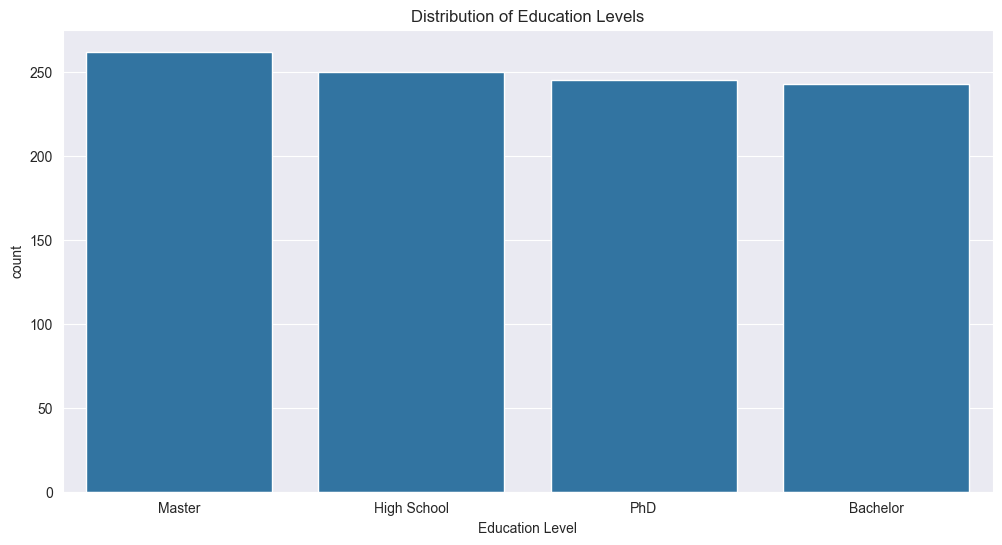

In [33]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Education Level', data=df,)
plt.title('Distribution of Education Levels')
plt.show()

### Loan Amount Distribution by Education Level

My next visualization is a box plot which showcases how loan amounts could vary between education levels within the dataset. This will help examine whether certain education levels tend to receive higher / lower loan amounts. On the bottom of the box plot it has the different ranking of the person *High School* - *PhD* while on the left side the loan amount in millions is shown.

The general observations from this visualization are that education level alone might not be a good predictor for suggesting the loan amount as it is sparse from different fields and that there are large spreads within the loan amounts.

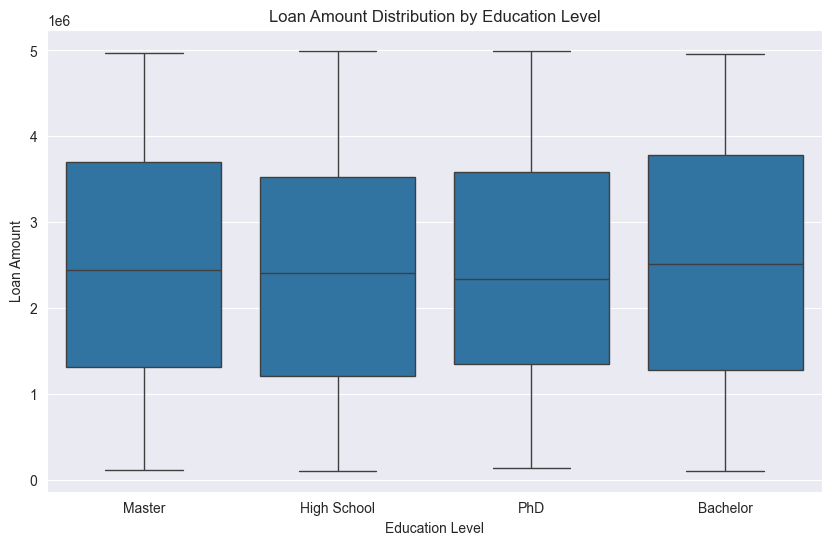

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education Level', y='Loan Amount', data=df)
plt.title('Loan Amount Distribution by Education Level')
plt.show()

<Figure size 4000x1000 with 0 Axes>

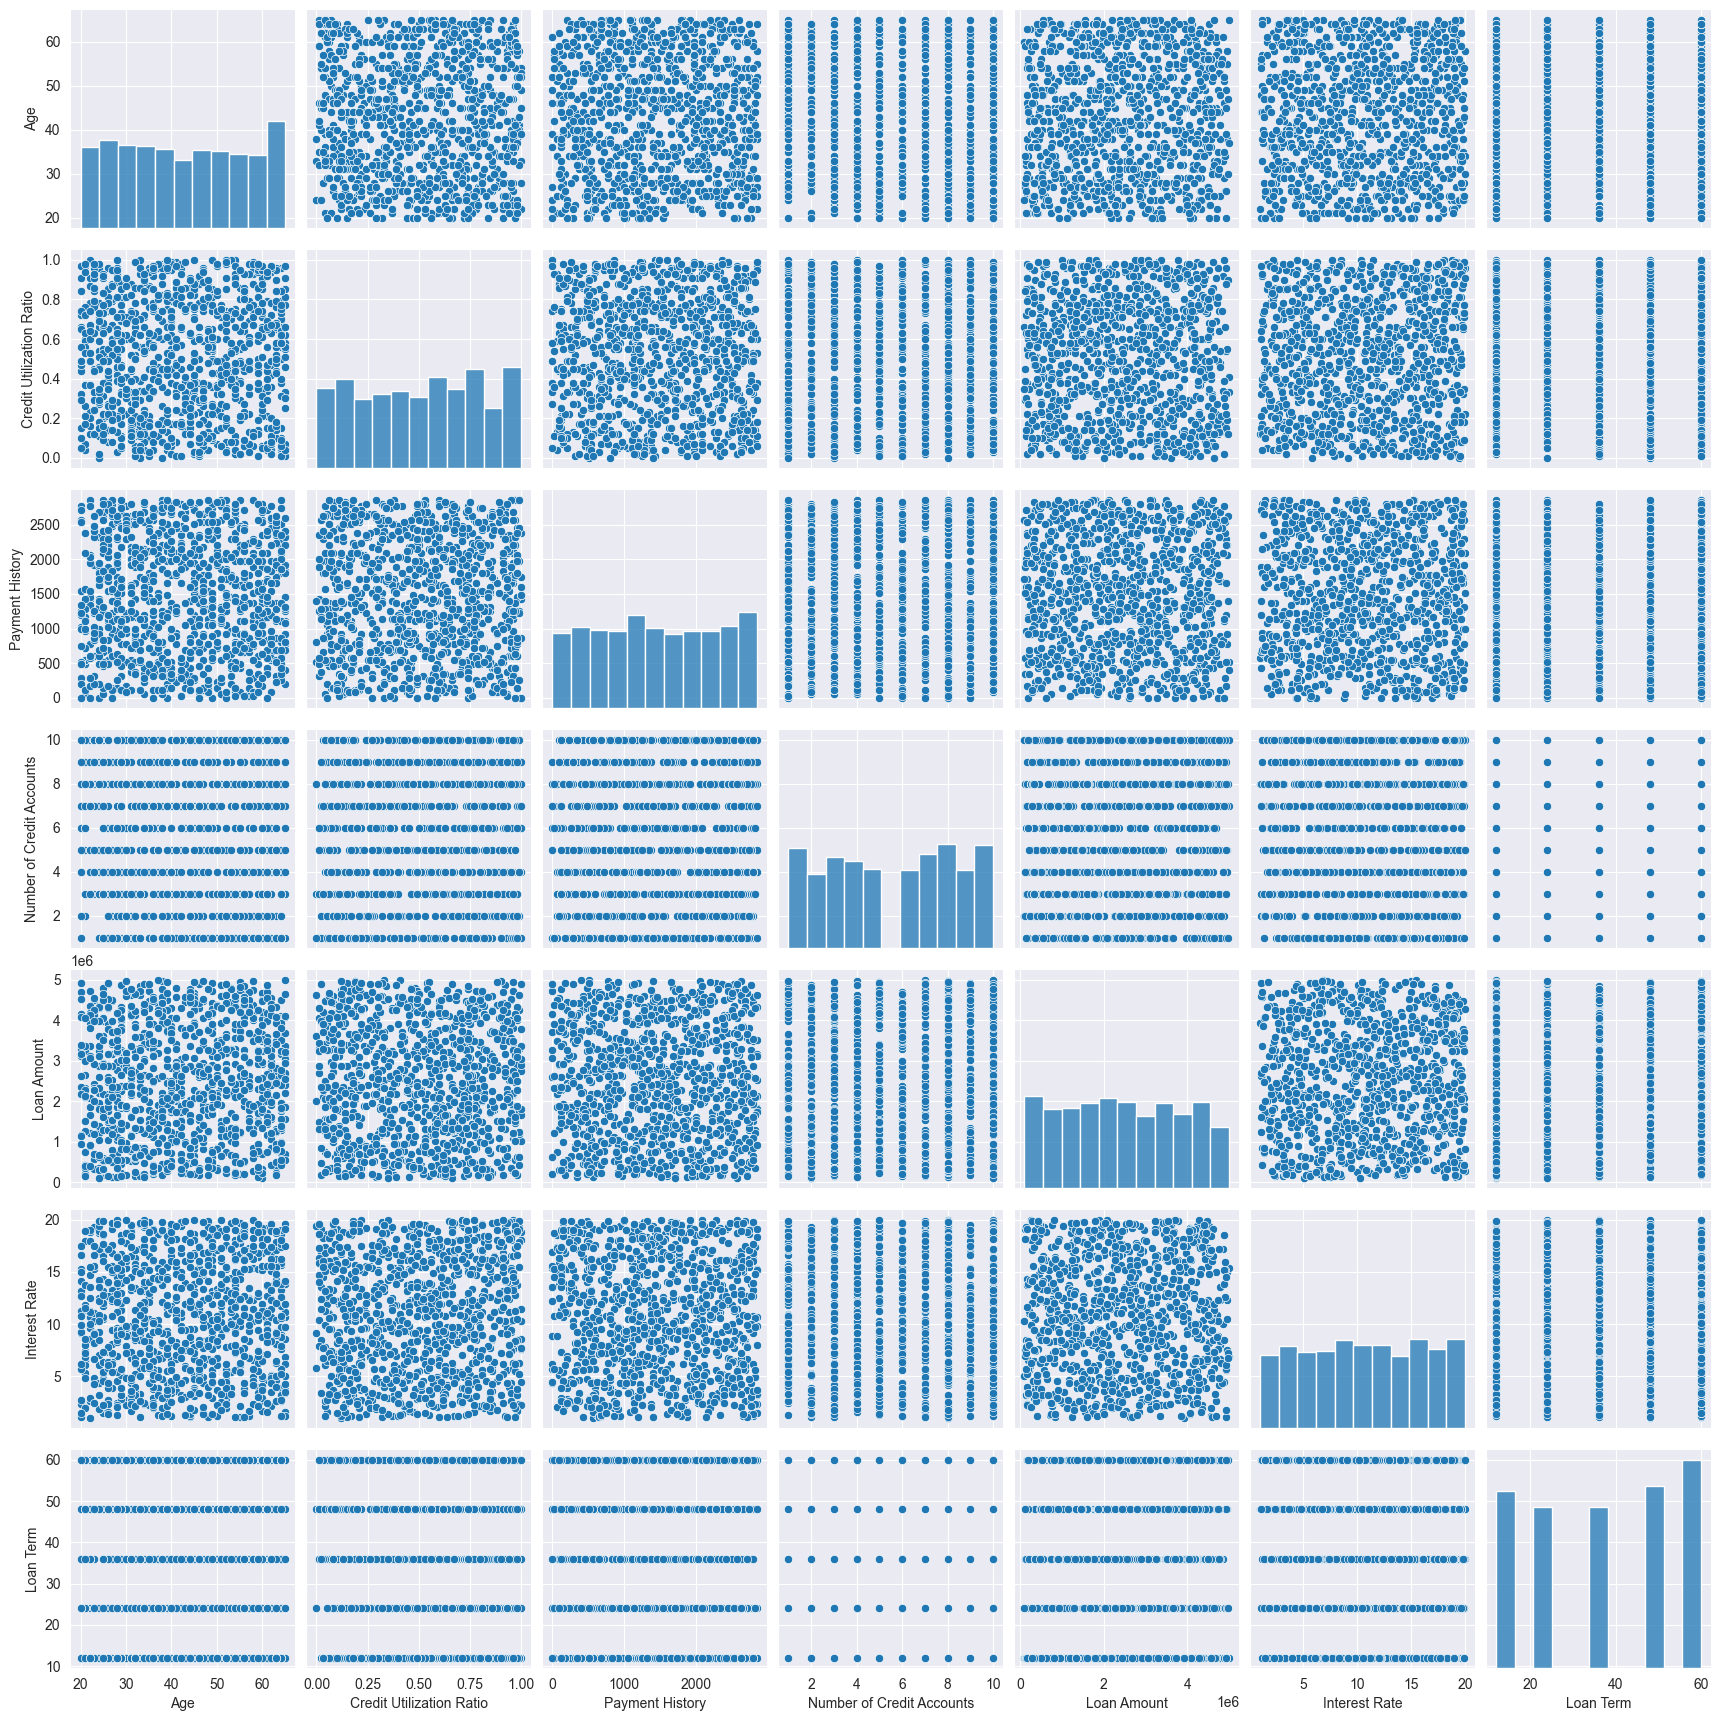

In [35]:
plt.figure(figsize=(40, 10))
sns.pairplot(df.select_dtypes(include=['number']))
plt.show()

### Encoding Data

Another part of the data pre-processing is going to revolve around [encoding](https://dagster.io/glossary/data-encoding) the dataset. Since I have several categorical values like Gender, Marital Status, etc. and I would like to group them into determination of whether a person holds a high or low creditworthiness categorizing the data into certain features helps allow the machine learning models to work with numerical data. To help with encoding my data, I will be using [One Hot Encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding/).

One Hot Encoding is a method to convert categorical variables into a binary format for the machine to be able to work with. A new column will be created for each new category needed. For example, with the `Gender` column information uses the text Female or Male but the machine cannot directly work with that information. Having one column that is set to Gender Male and another for Female with holding a true or false statement seems to help the machine make effective use of the data.

In [36]:
labels = {}

one_hot_labels = ["Gender", "Marital Status", "Employment Status", "Type of Loan"]
ordinal_data = ["Education Level"]

education_order = {"High School": 0, "Bachelor": 1, "Master": 2, "PhD": 3}
df["Education Level"] = df["Education Level"].map(education_order)

df = pd.get_dummies(df, columns=one_hot_labels, drop_first=True)

df.head()


,Age,Education Level,Credit Utilization Ratio,Payment History,Number of Credit Accounts,Loan Amount,Interest Rate,Loan Term,Gender_Male,Marital Status_Married,Marital Status_Single,Employment Status_Self-Employed,Employment Status_Unemployed,Type of Loan_Home Loan,Type of Loan_Personal Loan
0,60,2,0.22,2685.0,2,4675000,2.65,48,True,True,False,False,False,False,True
1,25,0,0.20,2371.0,9,3619000,5.19,60,True,True,False,False,True,False,False
2,30,2,0.22,2771.0,6,957000,2.76,12,False,False,True,False,False,False,False
3,58,3,0.12,1371.0,2,4731000,6.57,60,False,True,False,False,True,False,False
4,32,1,0.99,828.0,2,3289000,6.28,36,True,True,False,True,False,False,True



### Correlation Heatmap

Before doing any model training, we should try to examine key patterns within the dataset. One way to indentify the correlation between different fields is either using a correlation heatmap or a pair plot. Since we have already encoded our dataset, and we are exploring multiple different fields, a correlation heatmap keeps everything concise and easy to visualize.

Some main observations to highlight are:
- *Negative Correlations*:
    - `Marital Status_Single` and `Marital Status_Married` shares a negative correlation of `-0.51` which is expected as someone cannot be married and single at the same time
    - `Employment Status_Self-Employed` and `Employment Status_Unemployed` share a negative correlation for a similar reason
    -  `Type of Loan_Home Loan` and `Type of Loan_Personal Loan` share a negative correlation which could mean that if someone has one type of loan they could have picked that over the other
- *Interesting Observations*:
    - Age & Loan Type (Home)
        - Age shares a negative correlation with receiving a Home Loan which shows that older individuals are slightly less likely than older individuals to receive home loans
    -  Loan Term & Payment History
        -  Longer loan terms may correlate with having slightly worse payment histories, however, this is a very weak correlation at -0.05

While there were a few noticeable trends within the observations, there was not really a single factor that dominates evaluating the loan amount, credit utilization to evaluate our total credit risk. For us to predict creditworthiness, this will require looking at several features compared to one, and we will do so training several different models to make an examination.

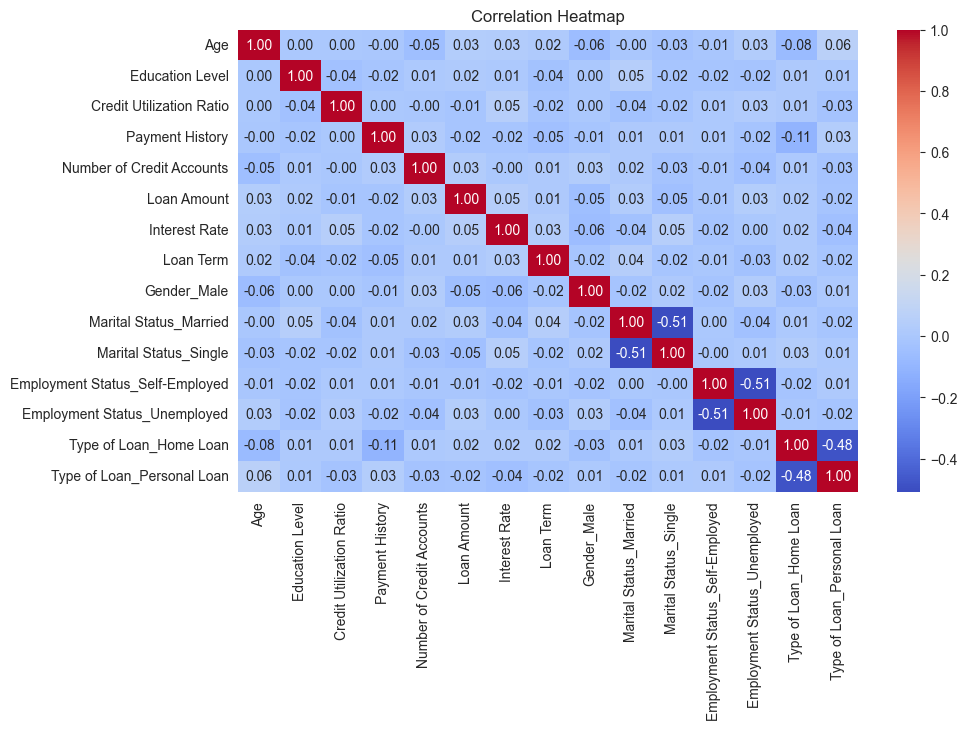

In [37]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Splitting and Training Dataset

Before training the machine models, we need to prepare the dataset by ensuring all features are in the correct format for numerical analysis and then split the data training and tests.

1. Categorizing Payment History
    - The `Payment History` column holds numerical values but to evaluate risk we need to set a point and convert these into three categories
        1. Bad - Poor Payment History
        2. Fair - Moderate Payment History
        3. Good - Strong Payment History
    - The cuts are achieved using [`pd.qcut()`](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) which splits the dataset into three equally sized groups.
    - After the category labels are created they are then converted into numerical values using the `LabelEncoder` function:
        -   Bad: 0, Fair: 1, Good: 2
2. Defining Credit Risk
    - The `Credit Utilization Ratio` represents how much available credit a person is holding to use this with our classification we will divide `Credit Utilization into `Credit Risk`. A **High Risk** is defined if the credit utilization is above 30% and **Low Risk** otherwise.
3. Encoding Loan Type
   - Since `Type of Loan` is a category-based variable we need to also convert those into numerical values using the `LabelEncoder`. This allows the loan to be in several different categories and then the machine can work them as numerical values.



In [38]:
if 'Payment History' in df.columns:
    if df['Payment History'].dtype in ['float64', 'int64']:
        df['Payment History'] = pd.qcut(df['Payment History'], q=3, labels=["Bad", "Fair", "Good"])
        df["Payment History"] = df["Payment History"].astype(str)
        df["Payment History"] = LabelEncoder().fit_transform(df["Payment History"])

if 'Credit Utilization Ratio' in df.columns:
    df['Credit Risk'] = (df['Credit Utilization Ratio'] > .30).astype(int)

if 'Type of Loan' in df.columns:
    df['Type of Loan'] = df['Type of Loan'].astype(str)
    df['Type of Loan'] = LabelEncoder().fit_transform(df['Type of Loan'])

### Setting Up Categories

The next step is preparing the categorical data and newly formed numerical-based columns have the correct datatype which was specifically Payment History and the Loan Type.

In [39]:
categorical_cols = ['Payment History', 'Type of Loan']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)

if 'Credit Risk' in df.columns:
    df['Credit Risk'] = df['Credit Risk'].astype(int)

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = df[numerical_cols].astype(float)

print(df.columns)
df.head()

Index(['Age', 'Education Level', 'Credit Utilization Ratio', 'Payment History',
       'Number of Credit Accounts', 'Loan Amount', 'Interest Rate',
       'Loan Term', 'Gender_Male', 'Marital Status_Married',
       'Marital Status_Single', 'Employment Status_Self-Employed',
       'Employment Status_Unemployed', 'Type of Loan_Home Loan',
       'Type of Loan_Personal Loan', 'Credit Risk'],
      dtype='object')


,Age,Education Level,Credit Utilization Ratio,Payment History,Number of Credit Accounts,Loan Amount,Interest Rate,Loan Term,Gender_Male,Marital Status_Married,Marital Status_Single,Employment Status_Self-Employed,Employment Status_Unemployed,Type of Loan_Home Loan,Type of Loan_Personal Loan,Credit Risk
0,60.0,2.0,0.22,2,2.0,4675000.0,2.65,48.0,True,True,False,False,False,False,True,0.0
1,25.0,0.0,0.20,2,9.0,3619000.0,5.19,60.0,True,True,False,False,True,False,False,0.0
2,30.0,2.0,0.22,2,6.0,957000.0,2.76,12.0,False,False,True,False,False,False,False,0.0
3,58.0,3.0,0.12,1,2.0,4731000.0,6.57,60.0,False,True,False,False,True,False,False,0.0
4,32.0,1.0,0.99,0,2.0,3289000.0,6.28,36.0,True,True,False,True,False,False,True,1.0


## Modeling

Within this project, several different [machine learning models](https://www.geeksforgeeks.org/top-6-machine-learning-algorithms-for-classification/) are going to be used to predict credit risk and loan type classification as we will use these for indicators of creditworthiness.

The model uses consist of:
1. **Decision Tree Classifier**
    - Used to split the dataset into branches based on feature values to make predictions, this will make it easy to visualize classifications to interpret and analyze results.
2. **K-Nearest Neighbors**
    - Classifies data at data points based on the nearest neighbors by calculating the distance between a data point and its k-nearest neighbors then assigns the majority class
3. **Support Vector Machine (SVM)**
    -   SVM is a classical algorithm that finds the optimal plane to divide classes by mapping data points into a high dimensional space and maximizes the margin between different classes.
4. **Naive Bayes**
    - Naive Bayes is a classifier based on probability from the Bayes' theorem, assuming independence between features. This calculates the probability of a class given the feature values and selects the class with the highest probability.
5. **Random Forest**
    - Random forest is a learning method that builds several decision trees and combines the outputs where each tree is trained on a random subset of data, and the final prediction is based on a majority rule.
___

Each of these models will be evaluated using accuracy, precision, and F1-score. Additionally, visualizations will be made when possible with showcasing the classifications and the confusion matrices.


### Credit Ratio Utilization

### Decision Tree Classifier
For this section, a Decision Tree Classifier will be used to predict Credit Risk. The target variable y is associated with the credit risk which what is aimed to be predicted. To not affect the accuracy score, the Credit Risk and Credit Utilization Ration will be dropped from the dataset, since they both contribute to Credit Risk. The dataset is then split into 80% training and 20% testing, ensuring the model is trained on one portion and testing unseen data.

Some things to note:
- The max_depth is set to 5 to avoid the tree creating memorization
- The min_samples_split is set to 10 to require at least 10 samples to split
- The min_samples_leaf is set to 5 for there to be five samples per leaf to prevent overgrowth

We leave with the accuracy score of 68% meaning that a majority of the test cases were properly classified; however, this model does fail 32% of the time, making it not a very reliable measure.

In [40]:
X = df.drop(columns=['Credit Risk', 'Credit Utilization Ratio'])
y = df['Credit Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
tree_model.fit(X_train, y_train)
y_prediction = tree_model.predict(X_test)

print(f"Accuracy score: {accuracy_score(y_test, y_prediction)}")

Accuracy score: 0.68


#### Classification Report

The classification report represents key performance metrics of the Decision Tree helping understand the effectiveness of predicting Credit Risk. For some main observations, the recall for high-risk customers is 0.93, meaning the model correctly identifies most of the actual high-risk borrowers, showing that the model can be effective in flagging risky individuals. There is a low recall for low-risk customers at 0.08, meaning the model is not very effective at classifying low risk applicants and could put creditworthy people flagged at high risk.


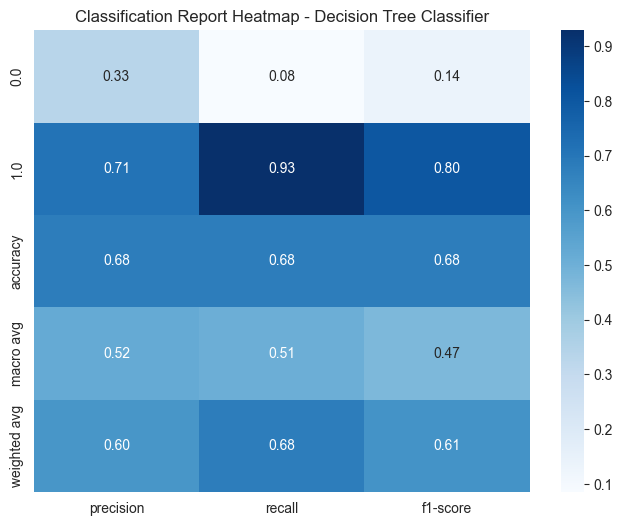

In [41]:
report_df = pd.DataFrame(classification_report(y_test, y_prediction, output_dict=True)).T

report_df = report_df.drop(columns=['support'], errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap - Decision Tree Classifier")
plt.show()

#### Confusion Matrix

The next portion is the evaluation of the confusion matrix, which is a 2x2 table that represents the True Label compared to the Predicted Label. As previously mentioned in the report, the model correctly identifies high risk individuals well, however, classifies many low-risk individuals as high risk.

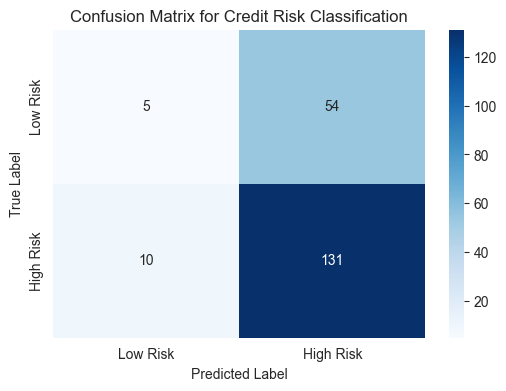

In [42]:
cm = confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Credit Risk Classification")
plt.show()

#### Decision Tree Visualization

The visualization of the decision tree provides a more intuitive structure to understand how the model made classification for predicting Credit Risk. The first decision point was divided into two branches based on several factors. The next two branches make a decision based on the credit utilization, if over 30 % of the branch leads to yes if not, but the loan amount is greater than 100,000 then the branch leans towards yes. The next internal nodes have several other features like examining through the payment history, interest rate, or number of accounts.

In [43]:
plt.figure(figsize=(100, 100))
plot_tree(tree_model, feature_names=X_train.columns, filled=True)
plt.title("Decision Tree Classifier & Credit Risk")
plt.show()

#### Important Features

The Feature Important Bar Graph provides an insight on which features contributed the most to the decision tree classifiers prediction of credit risk. This will show us what specific factors the model putting a category at high or low risk. The takeaway from this examination is that the loan amount seems to be the most predictive feature suggesting that requesting a larger loan puts an individual at a higher risk than others. A second factor s interest rate which could indicate that riskier credit alights more with the higher the interest rates. Some other factors of Age, Education, Gender seem to also play a smaller role.

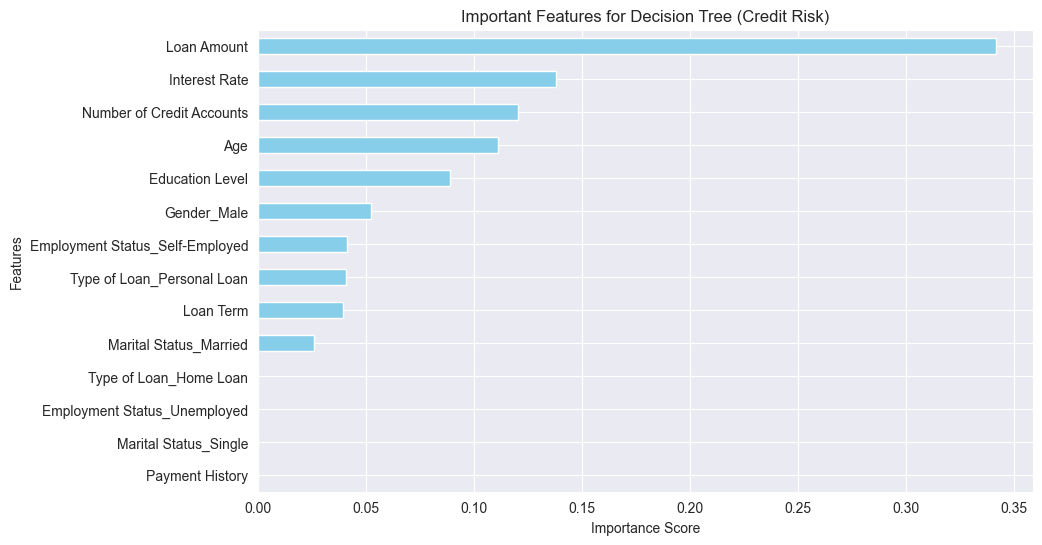

In [44]:
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title("Important Features for Decision Tree (Credit Risk)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

### SVM Classifier

This part implements an SVM classifier to additionally predict Credit Risk in cross-examination with the previous test. This will test whether a linear classification can improve performance. Similar to the previous test, X will include everything except the Credit Risk and y will be the feature we are testing.

The kernel is set to linear to make a decision boundary in repasting credit risk groups. The class weight is set to balance to adjust class importance and handle data imbalances properly.

In [45]:
X = df.drop(columns=['Credit Risk'])
y = df['Credit Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train, y_train)
y_prediction = svm.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_prediction)}")

Accuracy score: 0.36


#### Classification Report

The classification report heatmap for the SVM model shows that it does perform roughly well identified to low risk customers with a recall of 0.8, however, on the other side of identifying high risk customers with a recall of 0.18. This seems to be in contrast with the decision tree analysis. The overall accuracy of the report shows a 36% indicating that the linear kernel may not be effective for our task of classification.

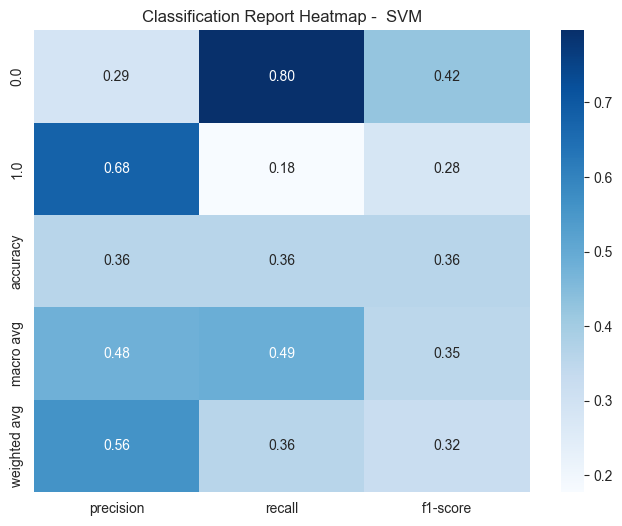

In [46]:
report_df = pd.DataFrame(classification_report(y_test, y_prediction, output_dict=True)).T

report_df = report_df.drop(columns=['support'], errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap -  SVM")
plt.show()

#### Confusion Matrix


The confusion matrix shows the model struggles with high risk of incorrectly labeling 116 cases

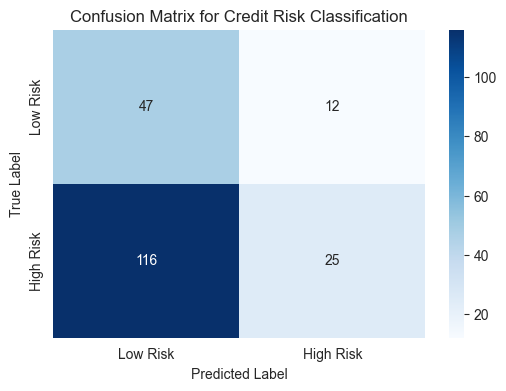

In [47]:
cm = confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Credit Risk Classification")
plt.show()

### Random Forest

This portion uses the Random Forest Classifier to also be part of the cross-examination, however, the result from this test shows an accuracy of 1.0 which could be the result due to some overfitting.

In [48]:
X = df.drop(columns=['Credit Risk'])
y = df['Credit Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_prediction = random_forest.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_prediction)}")

Accuracy score: 1.0


#### Classification Report

The classification report for the random forest suggests 100% accuracy showing that it seems to excell at correctly predicting information; however, this still needs to be examined due to some possible overfitting mentioned in the report.

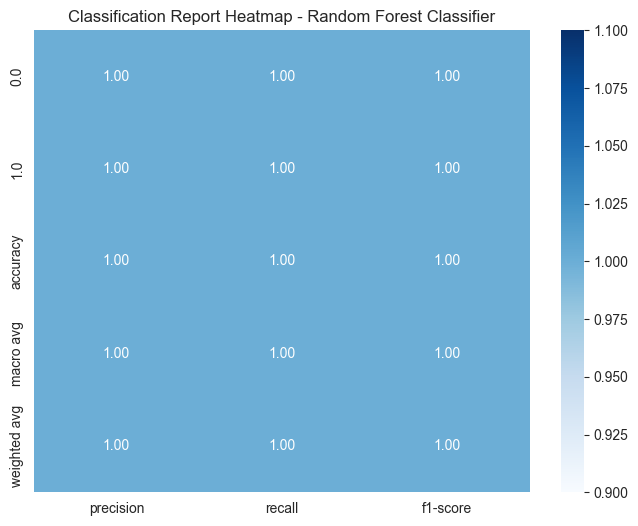

In [49]:
report_df = pd.DataFrame(classification_report(y_test, y_prediction, output_dict=True)).T

report_df = report_df.drop(columns=['support'], errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap - Random Forest Classifier")
plt.show()

#### Feature Importance's

This next portion showcases the feature importance that shows that the credit utilization ratio seems to predict the credit risk the most.

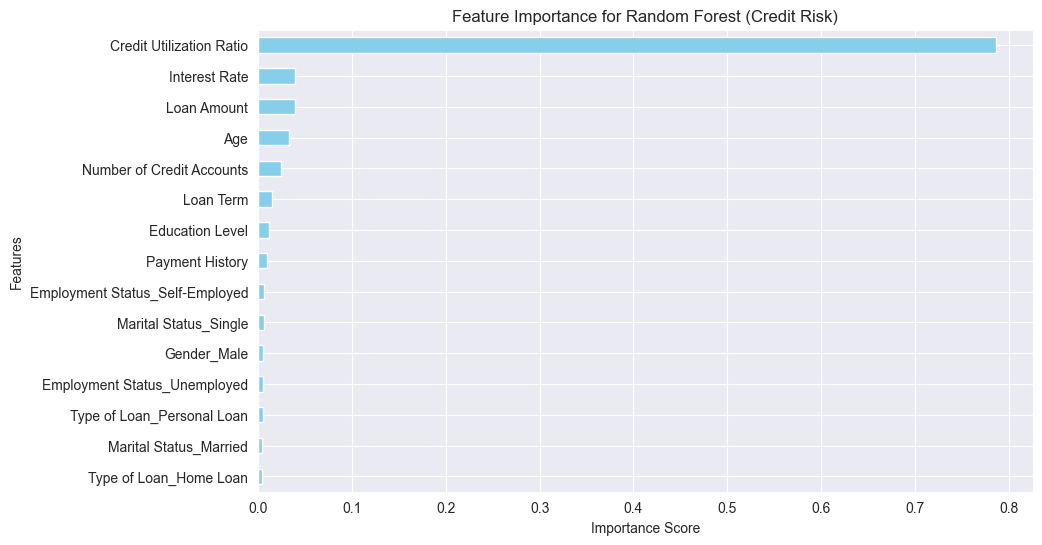

In [50]:
feature_importances = pd.Series(random_forest.feature_importances_, index=X.columns)


# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for Random Forest (Credit Risk)")
plt.show()

The correlation matrix shows that there were not misplaced classifications.

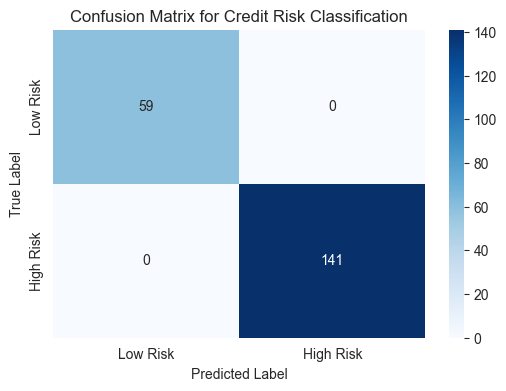

In [51]:
cm = confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Credit Risk Classification")
plt.show()

### Random Forest

The test will apply the Random Forest Classifier to predict the Payment History based on the other financial features. The accuracy score shows a result of 30% indicating that the model does not perform very well and this could be due to several factors.

In [52]:
X = df.drop(columns=['Payment History'])
y = df['Payment History']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_prediction = random_forest.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_prediction)}")

Accuracy score: 0.265


#### Classification Report

The report shows that the highest recall of 0.4 for class 1 (fair payment history) showing being slightly better than predicted compared to the other classes, however, 0.4 is still less than the majority.

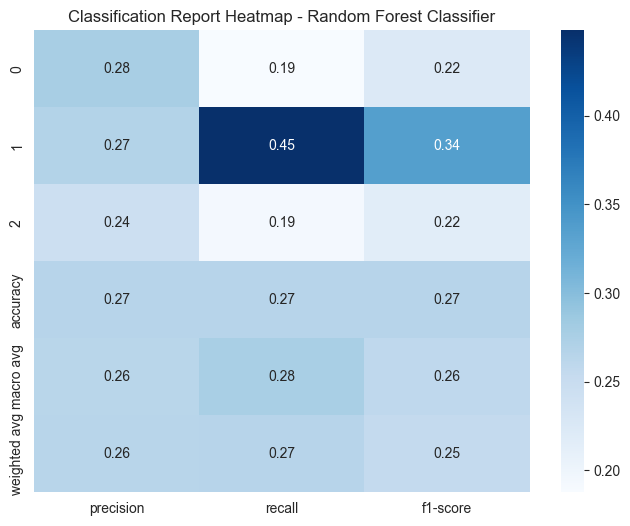

In [53]:
report_df = pd.DataFrame(classification_report(y_test, y_prediction, output_dict=True)).T

report_df = report_df.drop(columns=['support'], errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap - Random Forest Classifier")
plt.show()

#### Confusion Matrix

The confusion matrix for payment history shows a major classification with all classes being incorrectly predicted.

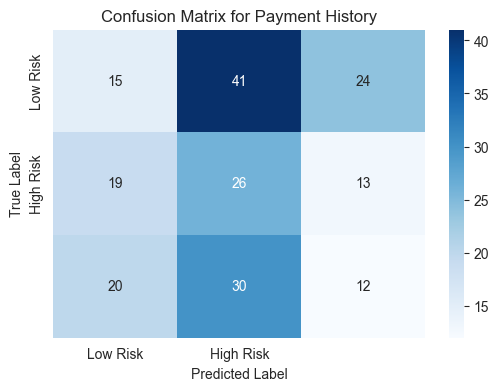

In [54]:
cm = confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Payment History")
plt.show()

### KNN Classifier

The K-Nearest Neighbors (KNN) classifier is used to predict Loan Type based on the other features. The result was an accuracy scoring of 55.5 %, showing that sure it does perform well compared to guessing but lacks a strong predictive measure.

Before the classification, there are a few steps that need to be taken:
1. the loan_column will be extracting all the column names that contain "Type of Loan" from the `df.columns` this way all columns that contain the representation of different loan types can be compared.
2. The next step is to apply a lambda function that converts the column names into readable labels by splitting the `_` and keeping the last part of the column (different between the _Personal and the _Home etc.)

In [55]:
loan_columns = [col for col in df.columns if "Type of Loan" in col]


df['Loan Type'] = df[['Type of Loan_Home Loan', 'Type of Loan_Personal Loan']].idxmax(axis=1)
df['Loan Type'] = df['Loan Type'].apply(lambda x: x.split('_')[-1])

X = df.drop(columns=['Loan Type'])
y = df['Loan Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_prediction = knn.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_prediction)}")

Accuracy score: 0.555


#### KNN Visualization

This visualization evaluates the different values for k compared to the accuracy, where the plot shows the accuracy score for the k-values ranging from 1 to 20, one observation is that after k = 9 the accuracy seems more stable.

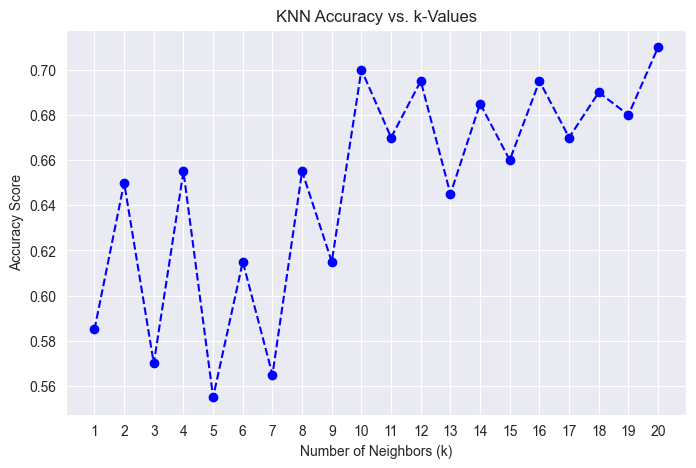

In [56]:
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred_k))


plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy Score")
plt.title("KNN Accuracy vs. k-Values")
plt.xticks(k_values)
plt.show()

#### Classification Report

The report for predicting the Loan Type shows a moderate report, performing better overall for Home Loans and seems to struggle with classifying personal lands.

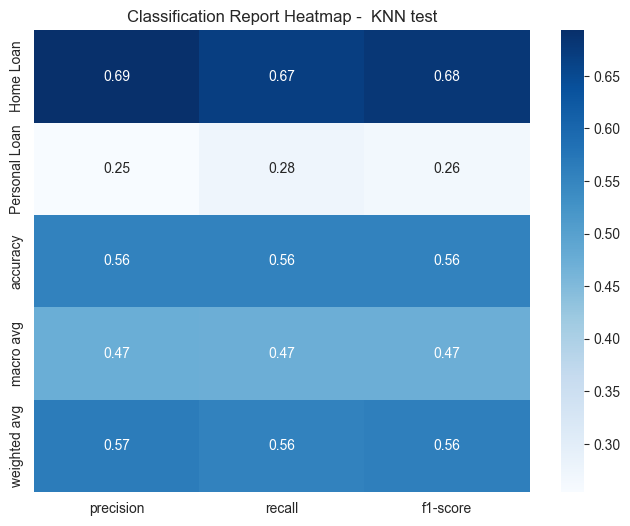

In [57]:
report_df = pd.DataFrame(classification_report(y_test, y_prediction, output_dict=True)).T

report_df = report_df.drop(columns=['support'], errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap -  KNN test")
plt.show()

#### Confusion Matrix

The confusion matrix shows the model correctly predicting low risk loans fairly well but predicting high risk at an alarming false positive rate.

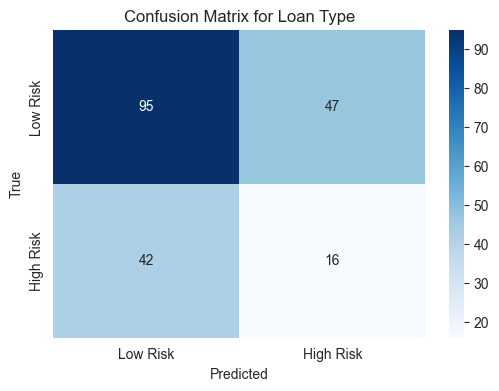

In [58]:
cm = confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Loan Type")
plt.show()

## Evaluation

The performance of the models varied significantly with some very low accuracy rates and some 100%. Each model was evaluated based on the classification report using the accuracy, recall, precision and f1 score, with some visualizations and the confusion matrix for each test.

The Decision Tree performed pretty well with a 68% accuracy and highlighted some key predictors for the credit risk. The random forest seemed to have issues with some overfitting, but other tests seemed to overlook the issue.

The Support Vector Machine struggled with accuracy of only 36 %, indicating that there may have been some issues with the tests used.

The KNN model had fair performance with the accuracy of 55%, and the other visualization sharing accuracy when checking the other k nearest points yielding better results. There were some limitations of evaluating the personal loan type.


Throughout all the confusion matrices, there seemed to be high false positives and negatives, especially more in the high risk classifications; this can pose a threat to a real world environment if an individual tries to base their decisions on these models. The models did seem to perform overall well identified to low risk individuals.


## Insights

Throughout this experiment, different models and features were explored. The key takeaways were:
- Loan Amount & Interest Play a Role
    - The feature importance of the decision tree and the random forests both showcase the loan amount and interest rate as influential factors predicting credit risk.
- Risk Mis-Classifications
    - Throughout looking at models, it seemed to struggle with properly identifying customers that were either low risk, classifying them as high risk or identifying high risk as low risk which was mainly seen in the SVM / KNN models.
- KNN and Hyperparameters
    - Compared to other models, it seemed that when adding higher number of neighbors to the KNN model, we could see the accuracy stabilizing more which brings a case to more parameter hypertrophying

When evaluating the initial question of being able to predict the creditworthiness of an individual, the answer seems to be a soft *yes, however,* not all models performed equally. Some are hard to see where the predictions could stem from and be applied. It seemed that Random Forest and KNN seemed to perform the best compared to other models. While Random Forest did have accuracy of 100%, overfitting could be a reason to why the accuracy is such a high level.

The features that seemed to impact credit risk the most aside from credit utilization wore the loan amount, interest rate, and number of accounts. The Payment History did not seem to contribute at all to the features, meaning that there are a lot more components to take into account than I initially thought.

## Impacts

The application of machine learning with financial data seems to have a lot of crucial impact affecting individuals, companies and institutions. While these models can be used to enhance lives, they can also pose several risks and ethical dilemmas.

**Social Impact**

By accounting, risk assessment, machine learning can help expand financial access to individuals who may not know a lot about traditional credit scoring and what they can do to build their financial record. Instead of just relying on what their base score is, they can look at the other factors that contribute to that score.

There could also be some concerns if the model is trained on data that might not account for all levels. For example, earlier we accounted for all different education levels, had representation within both genders and age, but what if we didn't account for race, origin, or financial levels? What if this model could be discriminating against those groups, and we did not know because it was not tested to account for those factors.

**Ethical Observations**

Although loan approvals—whether for personal or home loans—follow a data-driven approach, human bias can still influence decisions if they do not rely solely on objective models. Therefore, these models must be explainable and interpretable to clearly justify why an individual was denied credit and accurately assess their risk level.

**Real World**

One key issue observed in the model evaluations is the alarming high false rates within high risk individuals. This means that applicants who should be classified as high risk were misclassified as low risk, and this also can hold for vice versa. Which in the real world, this could lead to lenders approving loans to risky individuals and denying loans to individuals who would normally be approved.

While machine learning has a great ability to improve financial decision-making throughout several different domains, there also are the ethical, social, and real world traces that get left.


## References

1. GeeksforGeeks. (n.d.). Top 6 machine learning algorithms for classification. Retrieved February 22, 2025, from https://www.geeksforgeeks.org/top-6-machine-learning-algorithms-for-classification/
2. Pandas cut. (n.d.). pandas.qcut — Pandas documentation. Retrieved February 22, 2025, from https://pandas.pydata.org/docs/reference/api/pandas.qcut.html
3. Dagster. (n.d.). Data encoding - Dagster glossary. Retrieved February 22, 2025, from https://dagster.io/glossary/data-encoding
4.	GeeksforGeeks. (n.d.). One-hot encoding in machine learning. Retrieved February 22, 2025, from https://www.geeksforgeeks.org/ml-one-hot-encoding/
5.	Sharma, A. (n.d.). Credit scoring data. Kaggle. Retrieved February 22, 2025, from https://www.kaggle.com/datasets/cs49adityarajsharma/credit-scoring-data


## Code

The link to the notebook file can be found [Here]()